# DataFrame operations

DataFrame operations refer to the various actions and transformations that can be applied to a DataFrame in Apache Spark. DataFrames are a fundamental data structure in Spark that represent distributed collections of data organized into named columns, similar to a table in a relational database. DataFrame operations allow you to manipulate, analyze, and process data efficiently in a distributed and parallel manner.
This notebook presents common DataFrame operations for efficient data manipulation, analysis, and distributed processing.

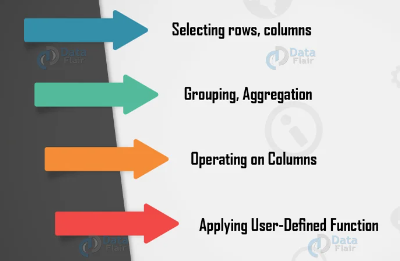

### Import the necessary libraries.

In [1]:
# Import the findspark library to locate and initialize Spark
import findspark
findspark.init()

# Import necessary components from PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

In [ ]:
# create a spark session
spark = SparkSession.builder.getOrCreate()

In [ ]:
# If you don’t want to specify the schema, Spark can infer schema
# from a sample at a lesser cost. For example, you can use the
# samplingRatio option:
sampleDF = spark.read.option("samplingRatio", 0.001).option("header", True).csv("/home/hhhhh/Data/sf-fire-calls.csv")

In [ ]:
sampleDF.printSchema()

root
 |-- CallNumber: string (nullable = true)
 |-- UnitID: string (nullable = true)
 |-- IncidentNumber: string (nullable = true)
 |-- CallType: string (nullable = true)
 |-- CallDate: string (nullable = true)
 |-- WatchDate: string (nullable = true)
 |-- CallFinalDisposition: string (nullable = true)
 |-- AvailableDtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- StationArea: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- OriginalPriority: string (nullable = true)
 |-- Priority: string (nullable = true)
 |-- FinalPriority: string (nullable = true)
 |-- ALSUnit: string (nullable = true)
 |-- CallTypeGroup: string (nullable = true)
 |-- NumAlarms: string (nullable = true)
 |-- UnitType: string (nullable = true)
 |-- UnitSequenceInCallDispatch: string (nullable = true)
 |-- FirePreventionDistrict: string (nullable = true)
 |-- Sup

In [ ]:
# Now that we have a sample DataFrame with an inferred schema (sampleDF),
# we can use this schema to read the full dataset with the correct data types.
fire_df = spark.read.csv('/home/hhhhh/Data/sf-fire-calls.csv', header=True, schema=sampleDF.schema)

In [ ]:
fire_df.printSchema()

root
 |-- CallNumber: string (nullable = true)
 |-- UnitID: string (nullable = true)
 |-- IncidentNumber: string (nullable = true)
 |-- CallType: string (nullable = true)
 |-- CallDate: string (nullable = true)
 |-- WatchDate: string (nullable = true)
 |-- CallFinalDisposition: string (nullable = true)
 |-- AvailableDtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- StationArea: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- OriginalPriority: string (nullable = true)
 |-- Priority: string (nullable = true)
 |-- FinalPriority: string (nullable = true)
 |-- ALSUnit: string (nullable = true)
 |-- CallTypeGroup: string (nullable = true)
 |-- NumAlarms: string (nullable = true)
 |-- UnitType: string (nullable = true)
 |-- UnitSequenceInCallDispatch: string (nullable = true)
 |-- FirePreventionDistrict: string (nullable = true)
 |-- Sup

Now that you have a distributed DataFrame composed of San Francisco Fire Department calls in memory, the first thing you as a developer will want to do is examine
your data to see what the columns look like. Are they of the correct types? Do any of
them need to be converted to different types? Do they have null values?

### Projections and filters:
A <i>projection</i> in relational parlance is a way to return only the
rows matching a certain relational condition by using filters. In Spark, projections are
done with the <b>select()</b> method, while filters can be expressed using the <b>filter()</b> or
<b>where()</b> method. We can use this technique to examine specific aspects of our SF Fire
Department data set:

In [ ]:
# Select 'IncidentNumber', 'AvailableDtTm', and 'CallType' columns from 'fire_df'
# Filter out rows where 'CallType' is 'Medical Incident'
few_fire_df = (fire_df
               .select("IncidentNumber", "AvailableDtTm", "CallType")
               .where(col("CallType") != "Medical Incident"))

# Display the first 5 rows of 'few_fire_df'
few_fire_df.show(5, truncate=False)
# This line of code will output the first 5 rows of 'few_fire_df' DataFrame


+--------------+----------------------+--------------+
|IncidentNumber|AvailableDtTm         |CallType      |
+--------------+----------------------+--------------+
|2003235       |01/11/2002 01:51:44 AM|Structure Fire|
|2003250       |01/11/2002 04:16:46 AM|Vehicle Fire  |
|2003259       |01/11/2002 06:01:58 AM|Alarms        |
|2003279       |01/11/2002 08:03:26 AM|Structure Fire|
|2003301       |01/11/2002 09:46:44 AM|Alarms        |
+--------------+----------------------+--------------+
only showing top 5 rows



In [ ]:
# Select 'IncidentNumber', 'AvailableDtTm', and 'CallType' columns from 'fire_df'
# Filter out rows where 'CallType' is 'Medical Incident'
(fire_df
 .select("IncidentNumber", "AvailableDtTm", "CallType")
 .where(fire_df["CallType"] != "Medical Incident")).show(5, truncate=False)
# This line of code will output the first 5 rows of the DataFrame where 'CallType' is not 'Medical Incident'


+--------------+----------------------+--------------+
|IncidentNumber|AvailableDtTm         |CallType      |
+--------------+----------------------+--------------+
|2003235       |01/11/2002 01:51:44 AM|Structure Fire|
|2003250       |01/11/2002 04:16:46 AM|Vehicle Fire  |
|2003259       |01/11/2002 06:01:58 AM|Alarms        |
|2003279       |01/11/2002 08:03:26 AM|Structure Fire|
|2003301       |01/11/2002 09:46:44 AM|Alarms        |
+--------------+----------------------+--------------+
only showing top 5 rows



What if we want to know how many distinct <b>CallTypes</b> were recorded as the causes
of the fire calls? These simple and expressive queries do the job:

In [ ]:
# Select the 'CallType' column from the 'fire_df' DataFrame and filter out rows where 'CallType' is not null.
# Then, aggregate the distinct values of 'CallType' and alias the result as 'DistinctCallTypes'.
# Finally, show the result.
fire_df.select('CallType').where(col('CallType').isNotNull()) \
       .agg(countDistinct('CallType').alias('DistinctCallTypes')).show()


+-----------------+
|DistinctCallTypes|
+-----------------+
|               30|
+-----------------+



We can list the distinct call types in the data set using these queries:

In [ ]:
# Select the 'CallType' column from the 'fire_df' DataFrame.
# Filter out rows where 'CallType' is not null using the 'isNotNull' condition.
# Then, apply the 'distinct()' function to get unique values in the 'CallType' column.
# Finally, display the first 10 unique 'CallType' values without truncating the output.
fire_df.select('CallType').where(col('CallType').isNotNull()).distinct().show(10, truncate=False)


+-----------------------------------+
|CallType                           |
+-----------------------------------+
|Elevator / Escalator Rescue        |
|Marine Fire                        |
|Aircraft Emergency                 |
|Confined Space / Structure Collapse|
|Administrative                     |
|Alarms                             |
|Odor (Strange / Unknown)           |
|Citizen Assist / Service Call      |
|HazMat                             |
|Watercraft in Distress             |
+-----------------------------------+
only showing top 10 rows



### Renaming, adding, and dropping columns:

Rename columns with the <b>withColumnRenamed()</b>
method. For instance, let’s change the name of our <b>Delay</b> column to <b>ResponseDelayedinMins</b> and take a look at the response times that were longer than five minutes:

In [ ]:
# Create a new DataFrame 'new_fire_df' based on the 'fire_df' DataFrame.
# Use the 'withColumnRenamed' method to rename the 'Delay' column to 'ResponseDelayedMins'.
new_fire_df = fire_df.withColumnRenamed('Delay', "ResponseDelayedMins")


<b><font color='red'>Note:</font></b> Because DataFrame transformations are immutable, when we
rename a column using <b>withColumnRenamed()</b> we get a new Data‐
Frame while retaining the original with the old column name.

In [ ]:
# Print the schema of the 'new_fire_df' DataFrame.
new_fire_df.printSchema()


root
 |-- CallNumber: string (nullable = true)
 |-- UnitID: string (nullable = true)
 |-- IncidentNumber: string (nullable = true)
 |-- CallType: string (nullable = true)
 |-- CallDate: string (nullable = true)
 |-- WatchDate: string (nullable = true)
 |-- CallFinalDisposition: string (nullable = true)
 |-- AvailableDtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- StationArea: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- OriginalPriority: string (nullable = true)
 |-- Priority: string (nullable = true)
 |-- FinalPriority: string (nullable = true)
 |-- ALSUnit: string (nullable = true)
 |-- CallTypeGroup: string (nullable = true)
 |-- NumAlarms: string (nullable = true)
 |-- UnitType: string (nullable = true)
 |-- UnitSequenceInCallDispatch: string (nullable = true)
 |-- FirePreventionDistrict: string (nullable = true)
 |-- Sup

In [ ]:
# Select the 'ResponseDelayedMins' column from the 'new_fire_df' DataFrame.
# Apply a filter to keep rows where 'ResponseDelayedMins' is greater than 5.
# Display the first 5 rows of the filtered DataFrame without truncating the output.
new_fire_df.select('ResponseDelayedMins').where(col('ResponseDelayedMins') > 5).show(5, False)


+-------------------+
|ResponseDelayedMins|
+-------------------+
|6.25               |
|7.25               |
|11.916667          |
|8.633333           |
|95.28333           |
+-------------------+
only showing top 5 rows



<b>--</b> Modifying the contents of a column or its type are common operations during data exploration. In some cases the data is raw or dirty, or its types are not amenable to being supplied as arguments to relational operators.<br>
<b>--</b> For example, in our <b>SF Fire</b>
Department data set, the columns <b>CallDate , WatchDate , and AlarmDtTm</b> are strings
rather than either <b>Unix timestamps</b> or <b>SQL dates</b>, both of which Spark supports and
can easily manipulate during transformations or actions (e.g., during a date- or time-
based analysis of the data).

### Steps:
<ol>
    <li>Convert the existing column’s data type from string to a Spark-supported timestamp.</li>
    <li>Use the new format specified in the format string <b>"MM/dd/yyyy"</b> or <b>"MM/dd/yyyy hh:mm:ss a"</b> where appropriate.</li>
    <li>After converting to the new data type, drop() the old column and append the new one specified in the first argument to the <b>withColumn()</b> method.</li>
    <li>Assign the new modified DataFrame to <b>fire_ts_df</b></li>
</ol>

In [ ]:
# Create a new DataFrame 'fire_ts_df' based on the 'new_fire_df'.
# Convert the 'CallDate' column to a timestamp format with the 'to_timestamp' function and rename it to 'IncidentDate'.
# Drop the original 'CallDate' column.
# Convert the 'WatchDate' column to a timestamp format with the 'to_timestamp' function and rename it to 'OnWatchDate'.
# Drop the original 'WatchDate' column.
# Convert the 'AvailableDtTm' column to a timestamp format with the 'to_timestamp' function and rename it to 'AvailableDtTs'.
# Drop the original 'AvailableDtTm' column.
fire_ts_df = (new_fire_df.withColumn('IncidentDate', to_timestamp(col("CallDate"), 'MM/dd/yyyy')).drop('CallDate')
                        .withColumn('OnWatchDate', to_timestamp(col('WatchDate'), 'MM/dd/yyyy')).drop('WatchDate')
                        .withColumn('AvailableDtTs', to_timestamp(col('AvailableDtTm'), 'MM/dd/yyyy hh:mm:ss a'))
                        .drop('AvailableDtTm'))


In [ ]:
# Select and display the first 5 rows of specific timestamp columns - 'IncidentDate', 'OnWatchDate', and 'AvailableDtTs'.
# The 'False' argument ensures that the output is not truncated.
fire_ts_df.select(['IncidentDate', 'OnWatchDate', 'AvailableDtTs']).show(5, False)


+-------------------+-------------------+-------------------+
|IncidentDate       |OnWatchDate        |AvailableDtTs      |
+-------------------+-------------------+-------------------+
|2002-01-11 00:00:00|2002-01-10 00:00:00|2002-01-11 01:51:44|
|2002-01-11 00:00:00|2002-01-10 00:00:00|2002-01-11 03:01:18|
|2002-01-11 00:00:00|2002-01-10 00:00:00|2002-01-11 02:39:50|
|2002-01-11 00:00:00|2002-01-10 00:00:00|2002-01-11 04:16:46|
|2002-01-11 00:00:00|2002-01-10 00:00:00|2002-01-11 06:01:58|
+-------------------+-------------------+-------------------+
only showing top 5 rows



Now that we have modified the dates, we can query using functions from <b>spark.sql.functions</b> like <b>month() , year() , and day()</b> to explore our data further.

In [ ]:
# Select the year from the 'IncidentDate' column of the 'fire_ts_df' DataFrame.
# Apply the 'distinct()' function to get unique year values.
# Order the unique year values in ascending order based on 'IncidentDate'.
# Display the ordered unique years.
fire_ts_df.select(year('IncidentDate'))
         .distinct()
         .orderBy(year('IncidentDate'))
         .show()


+------------------+
|year(IncidentDate)|
+------------------+
|              2000|
|              2001|
|              2002|
|              2003|
|              2004|
|              2005|
|              2006|
|              2007|
|              2008|
|              2009|
|              2010|
|              2011|
|              2012|
|              2013|
|              2014|
|              2015|
|              2016|
|              2017|
|              2018|
+------------------+



So far, we have explored a number of common data operations: reading and writing DataFrames; defining a schema and using it when reading in a DataFrame; saving a DataFrame as a Parquet file or table; projecting and filtering selected columns from an existing DataFrame; and modifying, renaming, and dropping columns.

## Aggregations.

### What were the most common types of fire calls?

In [ ]:
# Select 'CallType' column from 'fire_ts_df'
# Filter out rows where 'CallType' is not null
# Group by 'CallType' and count the number of occurrences for each group
# Order the result by 'count' in descending order
(fire_ts_df.select('CallType')
 .where(col('CallType').isNotNull())
 .groupBy('CallType')
 .count()
 .orderBy('count',ascending=False)
 .show(10,False)
)
# This line of code will output the top 10 'CallType' values based on their occurrence count


+-------------------------------+------+
|CallType                       |count |
+-------------------------------+------+
|Medical Incident               |113794|
|Structure Fire                 |23319 |
|Alarms                         |19406 |
|Traffic Collision              |7013  |
|Citizen Assist / Service Call  |2524  |
|Other                          |2166  |
|Outside Fire                   |2094  |
|Vehicle Fire                   |854   |
|Gas Leak (Natural and LP Gases)|764   |
|Water Rescue                   |755   |
+-------------------------------+------+
only showing top 10 rows



In [ ]:
# Select 'CallType' column from 'fire_ts_df'
# Filter out rows where 'CallType' is not null
# Group by 'CallType' and count the number of occurrences for each group, alias the count as 'CCC'
# Order the result by 'CCC' in descending order
(fire_ts_df.select('CallType')
 .where(col('CallType').isNotNull())
 .groupBy('CallType')
 .agg(count(col('CallType')).alias('CCC'))
 .orderBy('CCC',ascending=False)
 .show(10,False)
)
# This line of code will output the top 10 'CallType' values based on their occurrence count


+-------------------------------+------+
|CallType                       |CCC   |
+-------------------------------+------+
|Medical Incident               |113794|
|Structure Fire                 |23319 |
|Alarms                         |19406 |
|Traffic Collision              |7013  |
|Citizen Assist / Service Call  |2524  |
|Other                          |2166  |
|Outside Fire                   |2094  |
|Vehicle Fire                   |854   |
|Gas Leak (Natural and LP Gases)|764   |
|Water Rescue                   |755   |
+-------------------------------+------+
only showing top 10 rows



### What zip codes accounted for the most calls?

In [ ]:
# Select the 'zipCode' column from the 'fire_ts_df' DataFrame.
# Filter out rows where 'zipCode' is not null using the 'isNotNull' condition.
# Group the DataFrame by 'zipCode' and count the occurrences of each unique 'zipCode'.
# Order the results in descending order based on the count of occurrences.
# Display the top 10 'zipCode' values with their corresponding counts without truncating the output.
(fire_ts_df.select('zipCode')
 .where(col('zipCode').isNotNull())
 .groupBy('zipCode')
 .count()
 .orderBy('count',ascending=False)
 .show(10,False)
)

+-------+-----+
|zipCode|count|
+-------+-----+
|94102  |21840|
|94103  |20897|
|94110  |14801|
|94109  |14686|
|94124  |9236 |
|94112  |8421 |
|94115  |7812 |
|94107  |6941 |
|94122  |6355 |
|94133  |6246 |
+-------+-----+
only showing top 10 rows



## Other common DataFrame operations.
DataFrame API provides descriptive statistical methods like <b>min() , max() , sum() , and avg()</b>.

#### compute the sum of alarms, the average response time, and the minimum and maximum response times to all fire calls in our SF Fire Department data set

In [ ]:
# importing the PySpark functions in a Pythonic way so as not to conflict with the built-in Python functions:
import pyspark.sql.functions as F

In [ ]:
# Select and calculate aggregate values from the 'fire_ts_df' DataFrame.
# - Calculate the sum of 'NumAlarms'.
# - Calculate the average of 'ResponseDelayedMins'.
# - Calculate the minimum 'ResponseDelayedMins'.
# - Calculate the maximum 'ResponseDelayedMins'.
# Display the calculated aggregate values.
fire_ts_df.select(F.sum("NumAlarms"), F.avg("ResponseDelayedMins"),
                  F.min("ResponseDelayedMins"), F.max("ResponseDelayedMins")).show()


+--------------+------------------------+------------------------+------------------------+
|sum(NumAlarms)|avg(ResponseDelayedMins)|min(ResponseDelayedMins)|max(ResponseDelayedMins)|
+--------------+------------------------+------------------------+------------------------+
|      176170.0|      3.8923641541750342|             0.016666668|                    99.9|
+--------------+------------------------+------------------------+------------------------+



In [ ]:
# Select and calculate aggregate values from the 'fire_ts_df' DataFrame, with custom aliases for clarity.
# - Calculate the sum of 'NumAlarms' and alias it as "Alarms SUM".
# - Calculate the average of 'ResponseDelayedMins' and alias it as "Avg Response Mins".
# - Calculate the minimum 'ResponseDelayedMins' and alias it as "Min Response Mins".
# - Calculate the maximum 'ResponseDelayedMins' and alias it as "Max Response Mins".
# Display the calculated aggregate values with the specified aliases.
(fire_ts_df
 .select(F.sum("NumAlarms").alias("Alarms SUM "),F.avg("ResponseDelayedMins").alias("Avg Response Mins")
         ,F.min("ResponseDelayedMins").alias("Min Response Mins")
         ,F.max("ResponseDelayedMins").alias("Max Response Mins"))
 .show()
)

+-----------+------------------+-----------------+-----------------+
|Alarms SUM | Avg Response Mins|Min Response Mins|Max Response Mins|
+-----------+------------------+-----------------+-----------------+
|   176170.0|3.8923641541750342|      0.016666668|             99.9|
+-----------+------------------+-----------------+-----------------+



For more advanced statistical needs common with data science workloads, read the
API documentation for methods like <b>stat() , describe() , correlation() ,
covariance() , sampleBy() , approxQuantile() , frequentItems()</b> , and so on.